## 1 Generating Simulated Data

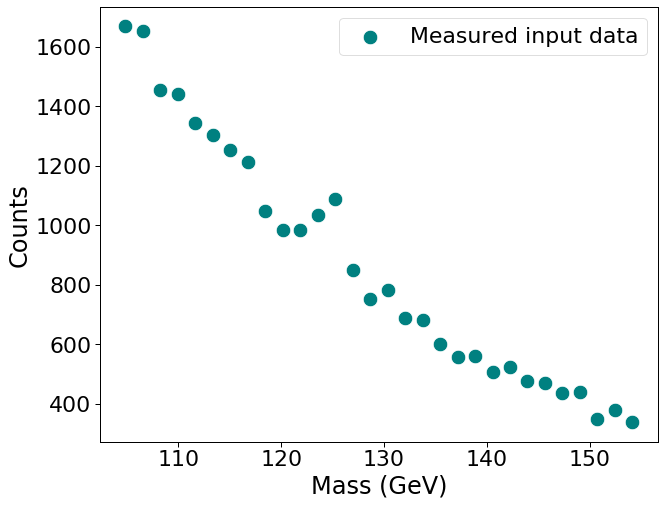

In [66]:
import matplotlib.pyplot as plt# Making plots.
import numpy as np# Random number generation.
import STOM_higgs_tools
import scipy as sp
import seaborn as sns
sns.set_context("paper", font_scale=2.5)
plt.figure(figsize=(10,8))
vals = STOM_higgs_tools.generate_data()

bin_heights, bin_edges = np.histogram(vals, range= [104, 155], bins = 30)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
sns.scatterplot(x=bin_centers,y=bin_heights,
                marker="o", color="teal", s=210, legend=False) ## using bin_centers rather than edges
plt.ylabel("Counts")
plt.xlabel("Mass (GeV)")
plt.legend(labels=['Measured input data'])
plt.show()

# 2 Background parametrisation

a) Determining the lambda

In [68]:
def lambd_chi2(lamb):
    CHi_indi=0
    for i in range(0,30):
        if bin_centers[i]<120:
            CHi_indi+=((((bin_heights[i]/bin_heights[0])-sp.e**(-(bin_centers[i]-bin_centers[0])/lamb))**2)/(bin_heights[i]/bin_heights[0]))
    return CHi_indi

lamb = sp.optimize.fmin(lambd_chi2,30,full_output=True,disp=False)[0]
print(lamb)

[33.02774048]


In [9]:
bin_centers

array([104.85, 106.55, 108.25, 109.95, 111.65, 113.35, 115.05, 116.75,
       118.45, 120.15, 121.85, 123.55, 125.25, 126.95, 128.65, 130.35,
       132.05, 133.75, 135.45, 137.15, 138.85, 140.55, 142.25, 143.95,
       145.65, 147.35, 149.05, 150.75, 152.45, 154.15])

b) $\int_{104.85}^{118.45}Ae^{\frac{-x}{\lambda}}=\left [  -\lambda A e^{\frac{-x}{\lambda}} \right ]^{118.45}_{104.85}$ which for $\lambda \approx 30 $ is roughly equal to 0.31A - the range is adjusted because of bin centers location.

In [70]:
import scipy as sp
from scipy import integrate
data_area = integrate.simps(bin_heights[bin_centers<=120], bin_centers[bin_centers<=120])
print(data_area/0.31)

60810.64516129033


The expected value for A is $\approx 6*10^4$

In [11]:
def background(params, x):
    #the background exponential function
    A, lamb = params
    return A*np.exp(-x/lamb)

def chi_2(measured, expected, plotting=False):
    #standard chi2
    chi_2 = np.sum((measured-expected)**2/expected, axis=0)
    return chi_2

def compare_params(params):
    #function for plotting given exp function on given histogram
    plt.figure(figsize=(10,8))
    sns.scatterplot(x=bin_centers,y=bin_heights, color="teal",
            marker="o", s=240, legend=False)
    sns.lineplot(x=bin_centers, y=background(params, bin_centers),
                 color="crimson", lw=5)
    plt.ylabel("Counts")
    plt.xlabel("Mass (GeV)")
    plt.legend(labels=['Estimated background','Measured input data'])
    plt.show()

c) It seems to be close to the actual background value.

In [69]:
compare_params([6e4, 29.43])

d) all of the other params were fitted

In [79]:
from scipy.optimize import fmin
from scipy.optimize import minimize



def fit_function(params):
    #the provided in the script uses reduced chi2
    A, lamb = params
    return STOM_higgs_tools.get_B_chi(vals, (104, 120), 9, A,lamb)


def make_minimize_cb(path=[]):
    #function to record the path of thre minimization
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

initial_val = np.array([3e4, 30.])
path_powell=[initial_val]
minimised_val_powell = minimize(fit_function,initial_val,
                                 method= 'Powell', callback=make_minimize_cb(path_powell))['x']
print(minimised_val_powell)
path_BFGS=[initial_val]
minimised_val_BFGS = minimize(fit_function,initial_val,
                                 method= 'BFGS', callback=make_minimize_cb(path_BFGS))['x']
print(minimised_val_BFGS)
path_simplex=[initial_val]
minimised_val_simplex = fmin(fit_function,initial_val, callback=make_minimize_cb(path_simplex))
print(minimised_val_simplex)

[5.85929461e+04 3.00162390e+01]
[5.21640402e+04 3.09871133e+01]
Optimization terminated successfully.
         Current function value: 2.513247
         Iterations: 96
         Function evaluations: 191
[5.21998034e+04 3.09813684e+01]


In [35]:
fit_function((3e4, 30))

895.3739829818878

In [14]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=bin_centers,y=bin_heights, color="teal",
        marker="o", s=240, legend=False)
sns.lineplot(x=bin_centers, y=background(minimised_val_simplex, bin_centers),
             color="crimson", lw=5)
plt.ylabel("Counts")
plt.xlabel("Mass (GeV)")
plt.legend(labels=['Fitted background','Measured input data'])
plt.show()

## The minimization plot

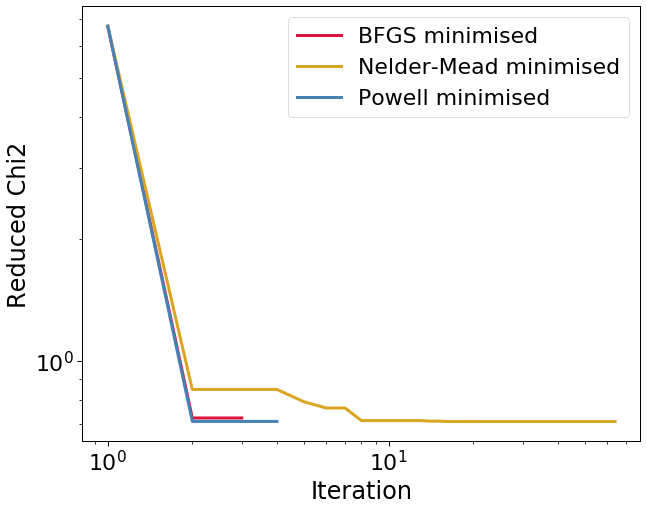

In [104]:
plt.figure(figsize=(10,8))
def plot_path(path, color):
    path_stacked = np.vstack(path)
    chi_2_progress = np.apply_along_axis(fit_function, 1, path_stacked)
    sns.lineplot(x=np.array(range(chi_2_progress.shape[0]))+1, y=chi_2_progress,
             color=color, lw=3)
    
    
plot_path(path_powell, "crimson")
plot_path(path_simplex, "goldenrod")
plot_path(path_BFGS, "steelblue")

plt.ylabel("Reduced Chi2")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iteration")
plt.legend(labels=['BFGS minimised','Nelder-Mead minimised', 'Powell minimised'])
plt.show()

The minimisation for less acurate values better illustrates the nature of those minimization methods.

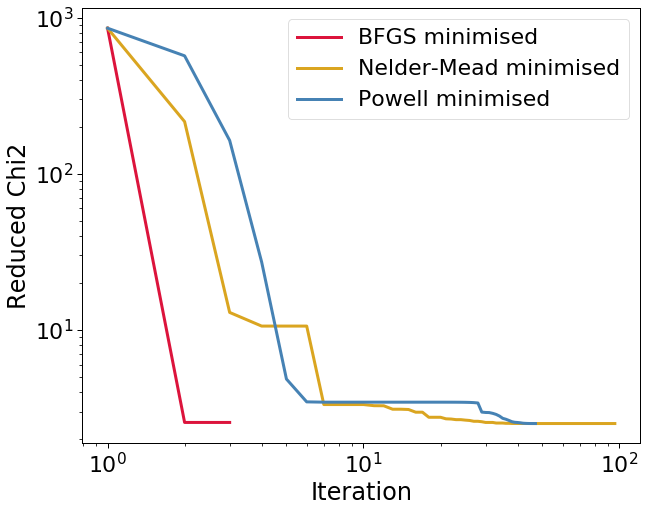

In [80]:
plt.figure(figsize=(10,8))
def plot_path(path, color):
    path_stacked = np.vstack(path)
    chi_2_progress = np.apply_along_axis(fit_function, 1, path_stacked)
    sns.lineplot(x=np.array(range(chi_2_progress.shape[0]))+1, y=chi_2_progress,
             color=color, lw=3)
    
    
plot_path(path_powell, "crimson")
plot_path(path_simplex, "goldenrod")
plot_path(path_BFGS, "steelblue")

plt.ylabel("Reduced Chi2")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iteration")
plt.legend(labels=['BFGS minimised','Nelder-Mead minimised', 'Powell minimised'])
plt.show()

# 3 Goodness of Fit

In [15]:
print(STOM_higgs_tools.get_B_chi(vals, (104, 120), 9, minimised_val_powell[0],minimised_val_powell[1]))
print(STOM_higgs_tools.get_B_chi(vals, (104, 120), 9, minimised_val_BFGS[0],minimised_val_BFGS[1]))
print(STOM_higgs_tools.get_B_chi(vals, (104, 120), 9, minimised_val_simplex[0],minimised_val_simplex[1]))

0.7765029190941651
0.7551453594479576
0.7551448640116083


All of the minimization methods achieved similar value of reduced chi squared around 0.75, calculated in the pre-peak region, which is slightly overfitted. We will use the original values for futher calculations.

# 4 Hypothesis testing

a)

In [16]:
reduced_chi2_whole_interval = (STOM_higgs_tools.get_B_chi(vals, (104, 155),
                                                          30, minimised_val_simplex[0],minimised_val_simplex[1]))
print(reduced_chi2_whole_interval)

4.672049110558582


In [17]:
from scipy import stats
p_val = 1-sp.stats.chi2.cdf(reduced_chi2_whole_interval, 1)
print(p_val)

0.03065732848221714


This p-value is below 0.05 and therefore we reject the hypothesis.

b) iterate over different bg signals - use the max likelihood method as the minimization is super slow.

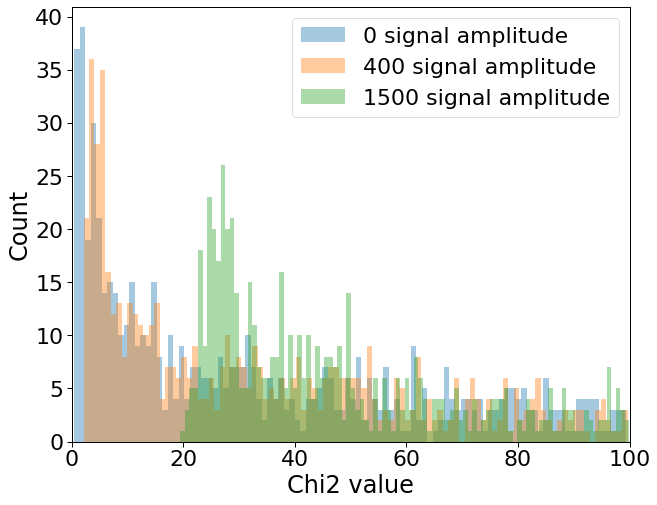

In [32]:
plt.figure(figsize=(10,8))

def get_params(vals):
    #calculates parameters for given generated values
    bin_heights, bin_edges = np.histogram(vals, range= [104, 155], bins = 30)
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    
    def lambd_chi2(lamb):
        CHi_indi=0
        for i in range(0,10):
            if bin_centers[i]<120:
                CHi_indi+=((((bin_heights[i]/bin_heights[0])-sp.e**(-(
                            bin_centers[i]-bin_centers[0])/lamb)
                            )**2)/(bin_heights[i]/bin_heights[0]))
        return CHi_indi
    lamb = sp.optimize.fmin(lambd_chi2,33,full_output=True,disp=False)[0]
    
    data_area = integrate.simps(bin_heights[bin_centers<=120], bin_centers[bin_centers<=120])
    A = data_area/0.31
    return A, lamb

# for different signal amplitudes
amplitudes = [0, 400, 1500]
for amplitude in amplitudes:
    chi2_vals = []
    for i in range(1000): # plot chi2 distribution of 1000 vals / 10k took too long
        new_vals = STOM_higgs_tools.generate_data(amplitude)
        params = get_params(new_vals)
        chi2_vals.append(STOM_higgs_tools.get_B_chi(new_vals, (104, 155), 30, params[0], params[1]))
    chi2_vals = np.array(chi2_vals)
    sns.distplot(chi2_vals[chi2_vals<=100], bins=100, kde=False, norm_hist=False) 
    #distribution from 0 to 100 for better readability
    #note this distribution values cannot be further integrated as the distribution is cut
    
plt.xlim(0, 100) 
plt.ylabel("Count")
plt.xlabel("Chi2 value")
plt.legend(labels=['0 signal amplitude', '400 signal amplitude', '1500 signal amplitude'])
plt.show()

c) do the same thing, just iterate over the generate data param

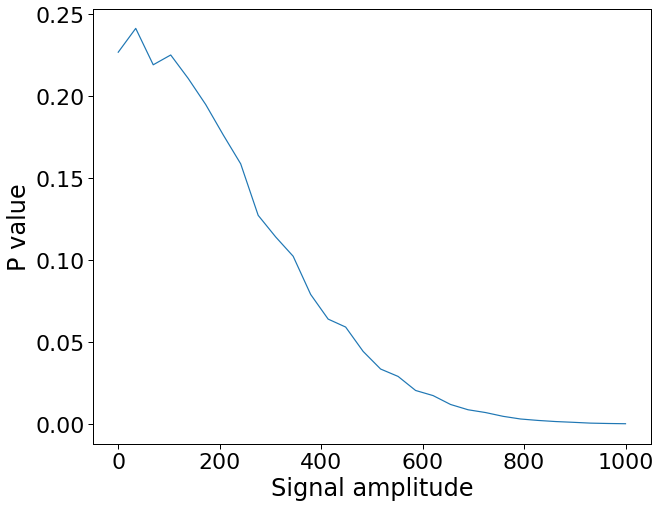

In [37]:
plt.figure(figsize=(10,8))
amplitude = np.linspace(0, 1000, 30)
def calc_p_val(params, vals):
    reduced_chi2_whole_interval = (STOM_higgs_tools.get_B_chi(vals, (104, 155),
                                                          30, minimised_val_simplex[0],minimised_val_simplex[1]))
    p_val = 1-sp.stats.chi2.cdf(reduced_chi2_whole_interval, 1)
    return p_val
pvals_average = []
for amp in amplitude:
    pvals = []
    for i in range(100):
        new_vals = STOM_higgs_tools.generate_data(int(amp))
        pvals.append(calc_p_val(get_params(new_vals), new_vals))
    pvals_average.append(np.average(pvals))  
plt.plot(amplitude, pvals_average)
plt.ylabel("P value")
plt.xlabel("Signal amplitude")
plt.show()

# 5 Signal estimation

In [40]:
from scipy import stats
def gauss(x, A_signal, mean, sigma):
    gauss = A_signal*stats.norm.pdf(x, loc=mean, scale=sigma)
    return gauss

In [71]:
def higgs_func(x, A, lambd, A_gauss, mean, sigma):
    return background((A, lambd), x) + gauss(x, A_gauss, mean, sigma)
final_chi2 = chi_2(bin_heights, higgs_func(bin_centers, 5.18351401e+04, 3.11391561e+01, 700, 125, 1.5))
reduced_final_chi2 = (final_chi2/(len(bin_heights)-2))
print(reduced_final_chi2)

4.796511705359873


In [72]:
from scipy import stats
p_val = 1-sp.stats.chi2.cdf(reduced_final_chi2, 1)
print(p_val)

0.02851742068026253


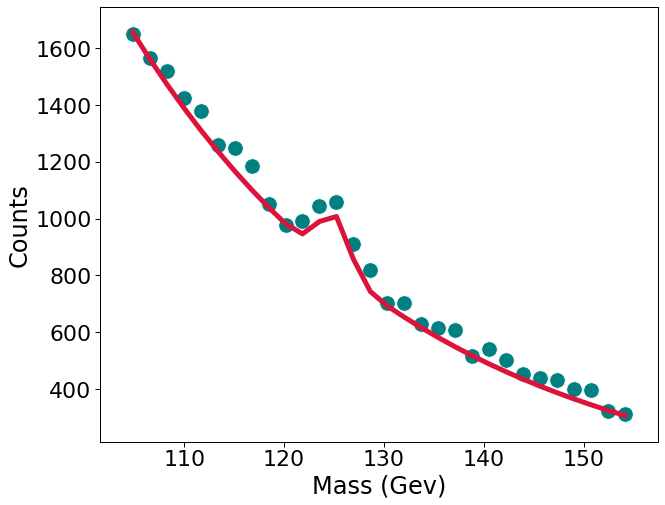

In [60]:
plt.figure(figsize=(10,8))
plt.plot(bin_centers, higgs_func(bin_centers, 5.98e4, 33.6, 700, 125, 1.5),
        color="crimson", lw=5)
sns.scatterplot(x=bin_centers,y=bin_heights, color="teal",
        marker="o", s=240, legend=False)
plt.ylabel("Counts")
plt.xlabel("Mass (Gev)")
plt.show()

## Iterating over the chi squared values.

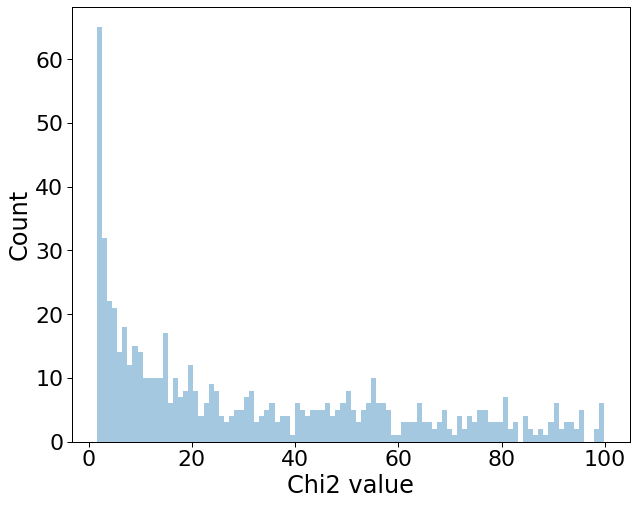

In [78]:
plt.figure(figsize=(10,8))
for i in range(1000):
    new_vals = STOM_higgs_tools.generate_data()
    params = get_params(new_vals)
    in_heights, bin_edges = np.histogram(new_vals, range= [104, 155], bins = 30)
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    chi = chi_2(bin_heights, higgs_func(bin_centers, params[0], params[1], 700, 125, 1.5))
    chi_values.append(chi/28)
chi_values = np.array(chi_values)
sns.distplot(chi_values[chi_values<=100], bins=100, kde=False, norm_hist=False) 
plt.ylabel("Count")
plt.xlabel("Chi2 value")
plt.show()

This distribution is centered mostly around 1, which signifies a good fit in most of the cases.